In [1]:
import os
#Set current location to the location of the script
os.chdir("/dust3r")
print(os.getcwd())

/dust3r


In [2]:
#Display imgs
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d
import torch
import json

from dust3r.inference import inference, inference_with_mask
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"
IMG_FILE_EXTENSION = ".png"
MASK_FILE_EXTENSION = ".png"
PREV_FRAME = 4
device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

#Open transforms
with open("{}/transforms.json".format(DATA_PATH)) as f:
    transforms = json.load(f)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [3]:
model_name = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth


instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [4]:
# load_images can take a list of images or a directory

images_array = []
masks_array = []

preset_focal = [transforms["fl_x"] for _ in range(PREV_FRAME+1)]
preset_pose = []
preset_mask = [True for _ in range(PREV_FRAME+1)]
preset_mask[-1] = False

for i in range(-PREV_FRAME,0):
    images_array.append(os.path.join(DATA_PATH,transforms["frames"][i]["file_path"]))
    masks_array.append(os.path.join(DATA_PATH,transforms["frames"][i]["mask_path"]))
    preset_pose.append(np.array(transforms["frames"][i]["transform_matrix"]))

images_array.append(os.path.join(DATA_PATH,"masked_images/{}{}".format(len(transforms["frames"]),IMG_FILE_EXTENSION)))
masks_array.append(os.path.join(DATA_PATH,"masks/{}{}".format(len(transforms["frames"]),MASK_FILE_EXTENSION)))
preset_pose.append(np.eye(4))

images = load_images(images_array, size=512, verbose=True)

masks = []

for i in range(len(masks_array)):
    #Open as mask and load to gpu
    mask = Image.open(masks_array[i]).convert('L')
    #Resize to match image size
    _,_,H,W = images[i]["img"].shape
    mask = mask.resize((W,H))

    mask = np.array(mask)
    mask = torch.tensor(mask).to(device)/255
    masks.append(mask)



>> Loading a list of 5 images
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/6.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/7.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/8.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/9.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/10.png with resolution 1280x720 --> 512x288
 (Found 5 images)


In [5]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference_with_mask(pairs, model, device, masks, batch_size=batch_size)
#output = inference(pairs, model, device, batch_size=batch_size)

view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

>> Inference with model on 20 image pairs


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


In [6]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.ModularPointCloudOptimizer)
scene.preset_focal(preset_focal, preset_mask)
scene.preset_pose(preset_pose, preset_mask)



 (setting focal #0 = 491.638671875)
 (setting focal #1 = 491.638671875)
 (setting focal #2 = 491.638671875)
 (setting focal #3 = 491.638671875)
 (setting pose #0 = [ 0.08779736 -0.01404059  0.03852846])
 (setting pose #1 = [ 0.11026087 -0.03048317  0.03406788])
 (setting pose #2 = [ 0.11806521 -0.04100279  0.08014522])
 (setting pose #3 = [ 0.11607814 -0.04993593  0.11948954])


In [7]:
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

 init edge (0*,3*) score=1.149208664894104
 init edge (0,4*) score=1.1482036113739014
 init edge (0,2*) score=1.1307114362716675
 init edge (0,1*) score=1.1098133325576782
 init loss = 0.006146085914224386
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps.0', 'im_depthmaps.1', 'im_depthmaps.2', 'im_depthmaps.3', 'im_depthmaps.4', 'im_poses.4', 'im_focals.4']


100%|██████████| 300/300 [00:27<00:00, 10.75it/s, lr=1.27413e-06 loss=0.000130587]


In [8]:
#Check if pointclouds folder exists
#If exists, delete all files in the folder
if os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    for file in os.listdir("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
        os.remove("{DATA_PATH}/pointclouds/{file}".format(DATA_PATH=DATA_PATH, file=file))
        
if not os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    os.makedirs("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH))

for i in range(len(images)):
    pointcloud = pts3d[i].detach().cpu().numpy()
    pointcloud = pointcloud.reshape(-1, 3)
    color = imgs[i].reshape(-1, 3)
    confidence_mask = confidence_masks[i].detach().cpu().numpy()
    confidence_mask = confidence_mask.reshape(-1)
    
    masked_pointcloud = []
    masked_color = []

    for j in range(len(confidence_mask)):
        if confidence_mask[j]:
            masked_pointcloud.append(pointcloud[j])
            masked_color.append(color[j])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(masked_pointcloud)
    pcd.colors = o3d.utility.Vector3dVector(masked_color)
    o3d.io.write_point_cloud("{DATA_PATH}/pointclouds/pointcloud{i}.ply".format(DATA_PATH=DATA_PATH, i=i), pcd)

(-0.5, 511.5, 287.5, -0.5)

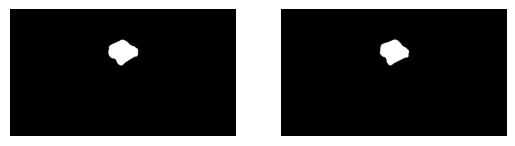

In [9]:
conf1 = confidence_masks[1].cpu().numpy()
conf2 = confidence_masks[2].cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(conf1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conf2, cmap='gray')
plt.axis('off')

In [14]:
new_frame = {
    "file_path" : "/".join(images_array[-1].split("/")[-2:]),
    "transform_matrix" : poses[-1].detach().cpu().numpy().tolist(),
    "mask_path" : "/".join(masks_array[-1].split("/")[-2:])
}
transforms["frames"].append(new_frame)

with open("{DATA_PATH}/transforms.json".format(DATA_PATH=DATA_PATH), "w") as f:
    json.dump(transforms, f, indent=4)